In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import files

In [ ]:

CONFIGURATION = {
    "BATCH_SIZE": 16,  # Increased for better convergence
    "IM_SIZE": 380,
    "LEARNING_RATE": 1e-4,
    "N_EPOCHS": 100,
    "DROPOUT_RATE": 0.6,  # Increased to combat overfitting
    "REGULARIZATION_RATE": 0.001,
    "CLASS_NAMES": ["ACNE", "NON-ACNE"],
    "N_FILTERS": 32,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 64,  # Reduced to avoid overfitting
    "N_DENSE_2": 32,  # Reduced to avoid overfitting
    "NUM_CLASSES": 2
}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Specify the path to your zip file and the extraction directory
zip_file_path = '/content/drive/MyDrive/BinaryModel.zip'
extract_to = '/content/Model_efficientNet'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Open and extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("File unzipped successfully!")

File unzipped successfully!


In [ ]:
train_directory = "/content/Model_efficientNet/BinaryModel/train"
val_directory = "/content/Model_efficientNet/BinaryModel/val"
test_directory = "/content/Model_efficientNet/BinaryModel/test"

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='binary',  # Use 'categorical' for one-hot encoded labels
    class_names=CONFIGURATION["CLASS_NAMES"],  # Ensure class names match the folder structure
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)


Found 11391 files belonging to 2 classes.


In [ ]:
print(train_dataset.class_names)


['ACNE', 'NON-ACNE']


In [ ]:
for images, labels in train_dataset.take(1):
    print("Labels: ", labels.numpy())


Labels:  [[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [ ]:
import tensorflow as tf

# Load the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='binary',  # Use 'categorical' for one-hot encoded labels
    class_names=CONFIGURATION["CLASS_NAMES"],  # Ensure class names match the folder structure
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=False,  # No need to shuffle validation data
    seed=99,
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='binary',  # Use 'categorical' for one-hot encoded labels
    class_names=CONFIGURATION["CLASS_NAMES"],  # Ensure class names match the folder structure
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=False,  # No need to shuffle validation data
    seed=99,
)


Found 1423 files belonging to 2 classes.
Found 1426 files belonging to 2 classes.


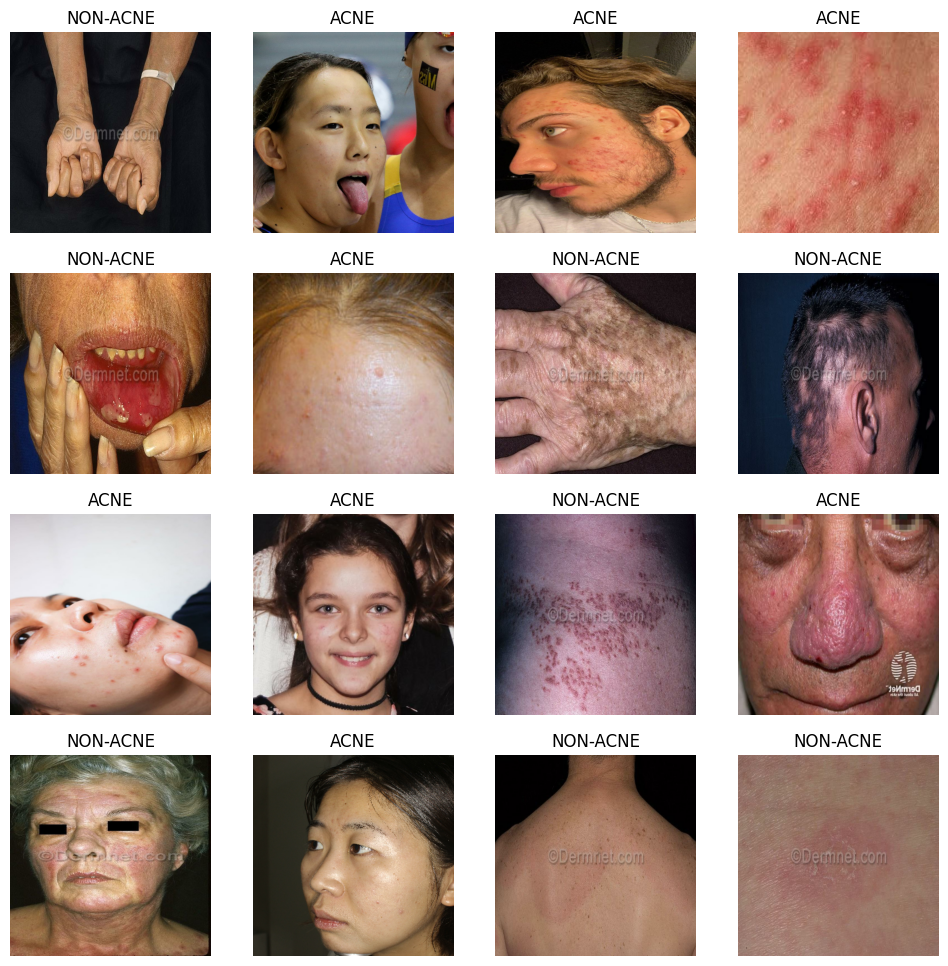

In [ ]:
plt.figure(figsize=(12, 12))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255.0)

        # Directly index CONFIGURATION["CLASS_NAMES"] using the label value as 0 or 1
        plt.title(CONFIGURATION["CLASS_NAMES"][int(labels[i])])
        plt.axis("off")


In [ ]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset = (
    validation_dataset
    .prefetch(tf.data.AUTOTUNE)
)
testing_dataset = (
    test_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
from tensorflow.keras.layers import Resizing,Rescaling
IM_SIZE = 380
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE,IM_SIZE),
    Rescaling(1./255),
])

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.models import Model

# Define Input Layer
inputs = Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))

# Define the EfficientNetB7 backbone
backbone = EfficientNetB7(include_top=False, weights='imagenet', input_tensor=inputs)

# Freeze most of the backbone layers, leaving the last 5 trainable
backbone.trainable = False
for layer in backbone.layers[-5:]:
    layer.trainable = True

# Add custom layers on top of EfficientNetB7
x = backbone.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce dimensionality
x = Dense(CONFIGURATION["N_DENSE_1"], activation="relu")(x)  # First dense layer
x = BatchNormalization()(x)  # Batch Normalization layer
x = Dense(CONFIGURATION["N_DENSE_2"], activation="relu")(x)  # Second dense layer
outputs = Dense(1, activation="sigmoid")(x)  # Output layer for binary classification

# Define the model
pretrained_model = Model(inputs, outputs)

# Print model summary
pretrained_model.summary()


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 380, 380, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 380, 380, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 380, 380, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 380, 380, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 381, 381, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 190, 190, 64)   │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 190, 190, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 190, 190, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 190, 190, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 190, 190, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 190, 190, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 64,263,960 (245.15 MB)

 Trainable params: 1,809,665 (6.90 MB)

 Non-trainable params: 62,454,295 (238.24 MB)

In [ ]:

pretrained_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)          │ (None, 7, 7, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         163,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,263,960 (245.15 MB)

 Trainable params: 1,809,665 (6.90 MB)

 Non-trainable params: 62,454,295 (238.24 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ModelCheckpoint to save the best weights
checkpoint_callback = ModelCheckpoint(
    filepath='best_weights_binary.keras',  # Updated filename for clarity
    monitor='val_binary_accuracy',         # Monitor validation binary accuracy
    mode='max',                            # Maximize validation accuracy
    verbose=1,                             # Display messages when saving
    save_best_only=True                    # Save only the best weights
)

# EarlyStopping to stop training early when no improvement
early_stopping_callback = EarlyStopping(
    monitor='val_binary_accuracy',         # Monitor validation binary accuracy
    mode='max',                            # Maximize validation accuracy
    patience=5,                            # Number of epochs with no improvement to wait
    verbose=1,                             # Display messages when stopping
    restore_best_weights=True              # Restore the best weights after stopping
)

# Combine both callbacks
callbacks = [checkpoint_callback, early_stopping_callback]

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_binary_accuracy',         # Monitor validation binary accuracy
    factor=0.5,                            # Reduce LR after no improvement
    patience=3,                            # Wait 3 epochs before reducing LR
    min_lr=1e-7                            # Minimum learning rate
)

callbacks.append(lr_scheduler)


In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import tensorflow as tf

# Use BinaryCrossentropy for binary classification
loss_function = BinaryCrossentropy()

# Custom F1 Score metric for binary classification
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define the metrics
metrics = [
    BinaryAccuracy(name='binary_accuracy'),  # For binary classification accuracy
    Precision(name="precision"),            # Precision for binary classification
    Recall(name="recall"),                  # Recall for binary classification
    F1Score(name="f1_score")                # Custom F1 score
]


In [ ]:
pretrained_model.compile(
    optimizer=Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = pretrained_model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    callbacks = checkpoint_callback
)

Epoch 1/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - binary_accuracy: 0.8830 - f1_score: 0.8846 - loss: 0.2767 - precision: 0.8640 - recall: 0.9071
Epoch 1: val_binary_accuracy improved from -inf to 0.96135, saving model to best_weights_binary.keras
712/712 ━━━━━━━━━━━━━━━━━━━━ 482s 537ms/step - binary_accuracy: 0.8831 - f1_score: 0.8846 - loss: 0.2766 - precision: 0.8640 - recall: 0.9071 - val_binary_accuracy: 0.9613 - val_f1_score: 0.9606 - val_loss: 0.1077 - val_precision: 0.9781 - val_recall: 0.9437
Epoch 2/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - binary_accuracy: 0.9561 - f1_score: 0.9558 - loss: 0.1192 - precision: 0.9490 - recall: 0.9628
Epoch 2: val_binary_accuracy improved from 0.96135 to 0.96767, saving model to best_weights_binary.keras
712/712 ━━━━━━━━━━━━━━━━━━━━ 293s 395ms/step - binary_accuracy: 0.9561 - f1_score: 0.9559 - loss: 0.1191 - precision: 0.9490 - recall: 0.9628 - val_binary_accuracy: 0.9677 - val_f1_score: 0.9672 - val_loss: 0.0789 - val_precision:

KeyboardInterrupt: 

In [ ]:
pretrained_model.evaluate(testing_dataset)

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation binary accuracy
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best')
plt.show()


Confusion Matrix:
 [[712   2]
 [  9 703]]


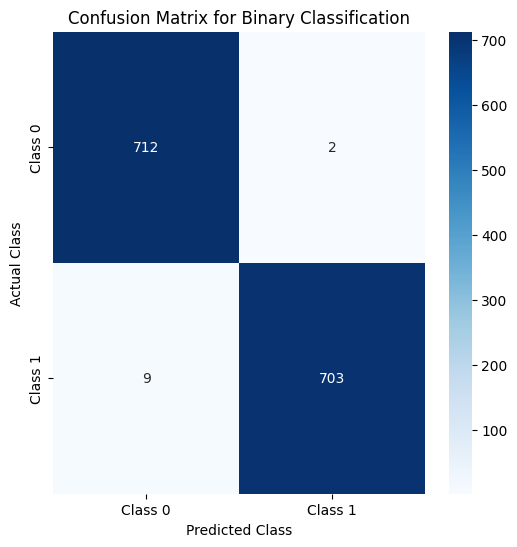

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted = []
labels = []

# Iterate through validation data
for images, label in testing_dataset:
    # Get predictions for the batch
    batch_preds = pretrained_model(images, training=False)

    # Convert probabilities to class labels (round for binary classification)
    batch_preds = np.round(batch_preds.numpy()).astype(int).flatten()
    predicted.extend(batch_preds)  # Collect all predictions

    # Flatten and collect true labels
    labels.extend(label.numpy().astype(int).flatten())  # Ensure labels are binary (0 or 1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predicted)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix as a heatmap with labels 0 and 1
plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["Class 0", "Class 1"],  # Binary classes
    yticklabels=["Class 0", "Class 1"]   # Binary classes
)
plt.title('Confusion Matrix for Binary Classification')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


In [ ]:
pretrained_model.save("/content/drive/MyDrive/efficientNetB7_first_model_9feb_functional.keras")

In [ ]:
pretrained_model.evaluate(testing_dataset)

Confusion Matrix:
 [[707   5]
 [ 17 694]]


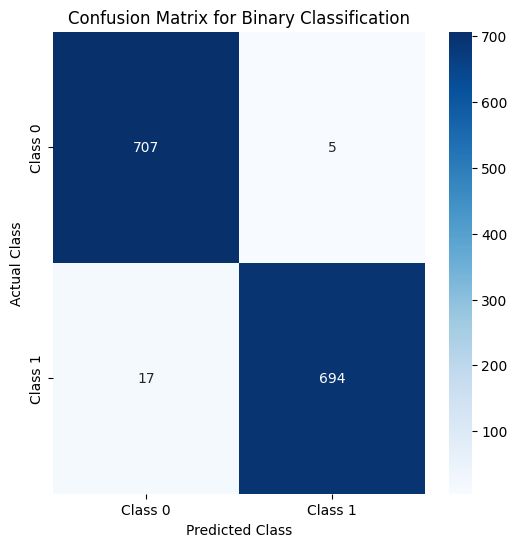

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted = []
labels = []

# Iterate through validation data
for images, label in val_dataset:
    # Get predictions for the batch
    batch_preds = pretrained_model(images, training=False)

    # Convert probabilities to class labels (round for binary classification)
    batch_preds = np.round(batch_preds.numpy()).astype(int).flatten()
    predicted.extend(batch_preds)  # Collect all predictions

    # Flatten and collect true labels
    labels.extend(label.numpy().astype(int).flatten())  # Ensure labels are binary (0 or 1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predicted)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix as a heatmap with labels 0 and 1
plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["Class 0", "Class 1"],  # Binary classes
    yticklabels=["Class 0", "Class 1"]   # Binary classes
)
plt.title('Confusion Matrix for Binary Classification')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


In [ ]:
pretrained_model.predict(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


array([[1.71816424e-02],
       [9.15420234e-01],
       [6.98699325e-04],
       [8.95591336e-04],
       [1.67907751e-03],
       [2.74240202e-03],
       [7.71330530e-03],
       [3.27883638e-03],
       [5.69074648e-04],
       [2.28329387e-04],
       [1.11259252e-03],
       [1.07554626e-02],
       [2.85551978e-05],
       [6.37131670e-05],
       [5.54147875e-04],
       [2.70661287e-04],
       [1.17252057e-04],
       [1.27773418e-03],
       [1.51777943e-03],
       [4.05889340e-02],
       [1.22678801e-04],
       [2.65502427e-02],
       [1.99243732e-04],
       [1.17003955e-01],
       [2.72117227e-01],
       [2.39421517e-01],
       [5.09066973e-04],
       [2.36410671e-03],
       [7.54401535e-02],
       [1.07619620e-03],
       [7.38451332e-02],
       [2.92009348e-03],
       [9.58766520e-01],
       [2.31315335e-03],
       [2.02993921e-04],
       [6.89038643e-05],
       [7.86885023e-02],
       [2.37936154e-02],
       [5.57692663e-04],
       [1.72573040e-04],


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Metric
import tensorflow as tf

# Define the custom F1Score metric if it was used during training
class F1Score(Metric):
    def __init__(self, name='f1_score', dtype=None):
        super(F1Score, self).__init__(name=name, dtype=dtype)
        self.true_positive = self.add_weight(name="tp", initializer="zeros")
        self.false_positive = self.add_weight(name="fp", initializer="zeros")
        self.false_negative = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)  # Convert predictions to binary (0 or 1)
        tp = tf.count_nonzero(y_true * y_pred)
        fp = tf.count_nonzero((y_pred) * (y_true - 1))
        fn = tf.count_nonzero((y_true) * (y_pred - 1))

        self.true_positive.assign_add(tp)
        self.false_positive.assign_add(fp)
        self.false_negative.assign_add(fn)

    def result(self):
        precision = self.true_positive / (self.true_positive + self.false_positive)
        recall = self.true_positive / (self.true_positive + self.false_negative)
        return 2 * (precision * recall) / (precision + recall)

    def reset_state(self):
        self.true_positive.assign(0)
        self.false_positive.assign(0)
        self.false_negative.assign(0)

model_path = "/content/drive/MyDrive/efficientNetB7_2_classes_2.keras"
model = load_model(model_path,custom_objects={"F1Score": F1Score})
model.predict(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step


array([[8.11448600e-03],
       [7.96599746e-01],
       [1.07092223e-04],
       [4.41320619e-04],
       [1.17249577e-03],
       [4.68129903e-04],
       [6.75042393e-04],
       [2.49184057e-04],
       [9.79786506e-04],
       [5.52589045e-05],
       [3.60406877e-04],
       [1.15808344e-03],
       [1.74549677e-06],
       [9.26950015e-05],
       [1.32294677e-04],
       [1.96588244e-05],
       [1.81211144e-04],
       [7.37701252e-04],
       [3.17619997e-03],
       [4.69529569e-01],
       [5.97204817e-05],
       [1.31426407e-02],
       [3.07618699e-04],
       [5.61486483e-02],
       [3.30399815e-03],
       [7.74893239e-02],
       [1.49698323e-03],
       [5.09024772e-04],
       [2.69332290e-01],
       [7.36009562e-03],
       [4.88660857e-03],
       [7.50920596e-03],
       [5.57358980e-01],
       [8.56100861e-03],
       [6.15658282e-05],
       [2.17222223e-05],
       [6.67446494e-01],
       [5.93813248e-02],
       [5.48423850e-04],
       [6.83325561e-05],


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import tensorflow.lite as tflite
from tensorflow.keras.models import load_model

# Load Keras Model without compiling
model_path = "/content/best_weights_binary_functional_disease.keras"
model = load_model(model_path, compile=False)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# **Comment out quantization if unsure about dataset**
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Ensure input/output remain FLOAT32
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert & Save
tflite_model = converter.convert()
tflite_model_path = "/content/disease_model_float.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# ================================
# **Load & Test the TFLite Model**
# ================================

# Image processing


Saved artifact at '/tmp/tmpddhjwccb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 380, 380, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138772280013840: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138772280013456: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138772684679568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138772684678224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138772684675536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138772684674768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138772684677840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138772684678032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138772661863632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138772661862672: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define TFLite model path in Google Drive
tflite_model_drive_path = "/content/drive/My Drive/2_class_final_6feb.tflite"

# Copy the model to Drive
!cp "/content/2_class_float.tflite" "$tflite_model_drive_path"

print(f"TFLite model saved at: {tflite_model_drive_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/2_class_float.tflite': No such file or directory
TFLite model saved at: /content/drive/My Drive/2_class_final_6feb.tflite


In [ ]:
import tensorflow.lite as tflite
import numpy as np
import tensorflow as tf

# Load the TFLite model
interpreter = tflite.Interpreter(model_path="/content/disease_model_float.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define test dataset
test_dataset = test_dataset
# Compute accuracy
correct_predictions = 0
total_samples = 0

for images, labels in test_dataset:
    # Convert images to float32 (ensure correct format)
    images = tf.cast(images, tf.float32)

    for i, image in enumerate(images):
        # Expand dims (TFLite expects batch dimension)
        input_tensor = np.expand_dims(image, axis=0)

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], input_tensor)

        # Run inference
        interpreter.invoke()

        # Get output and convert to class
        output = interpreter.get_tensor(output_details[0]['index'])
        predicted_class = 0 if output[0][0] <= 0.5 else 1  # Adjust if needed


        # Compare with ground truth
        if predicted_class == labels[i].numpy():
            correct_predictions += 1
            print("Correct prediction")
        else:
            print("Incorrect prediction")
        total_samples += 1

# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f"TFLite Model Accuracy on Test Set: {accuracy * 100:.2f}%")


Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct prediction
Correct pred

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define TFLite model path in Google Drive
tflite_model_drive_path = "/content/drive/My Drive/disease_model_final.tflite"

# Copy the model to Drive
!cp "/content/disease_model_final.tflite" "$tflite_model_drive_path"

print(f"TFLite model saved at: {tflite_model_drive_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/disease_model_final.tflite': No such file or directory
TFLite model saved at: /content/drive/My Drive/disease_model_final.tflite


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
keras_model_path = "/content/best_weights_binary_functional_disease.keras"
backup_path = "/content/drive/MyDrive/best_weights_binary_functional_disease.keras"

# Save a backup copy of the Keras model to Google Drive
shutil.copy(keras_model_path, backup_path)

print(f"Keras model saved to Google Drive at: {backup_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Keras model saved to Google Drive at: /content/drive/MyDrive/best_weights_binary_functional_disease.keras


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define source and destination paths
tflite_model_path = "/content/disease_model_float.tflite"  # Path where the model is saved
drive_save_path = "/content/drive/MyDrive/disease_float_final.tflite"  # Path in Google Drive

# Copy the TFLite model to Google Drive
!cp "{tflite_model_path}" "{drive_save_path}"

print(f"TFLite model saved to Google Drive at: {drive_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TFLite model saved to Google Drive at: /content/drive/MyDrive/disease_float_final.tflite
